In [1]:
%load_ext sql

In [17]:
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%config SqlMagic.autopandas = True

In [2]:
%cd ..

D:\Projects\Python\Groningen-Waste-Collection


In [15]:
%sql sqlite:///data/waste.db

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [76]:
%sql data << SELECT * FROM dumps;

Returning data to local variable data


In [77]:
data['date'] = pd.to_datetime(data.date)

<AxesSubplot:xlabel='date'>

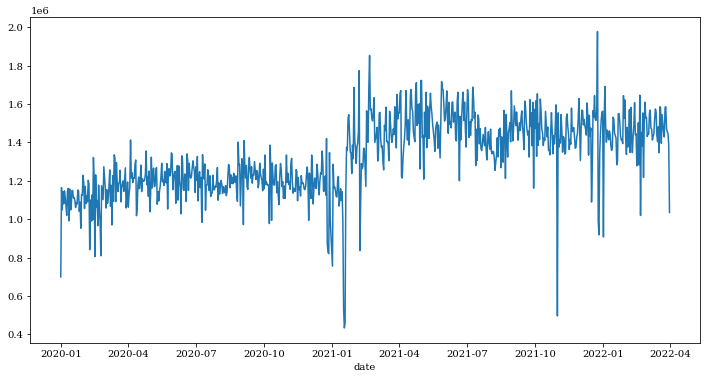

In [79]:
data.groupby(data.date.dt.date).bag_size.sum().plot(figsize=(12, 6))

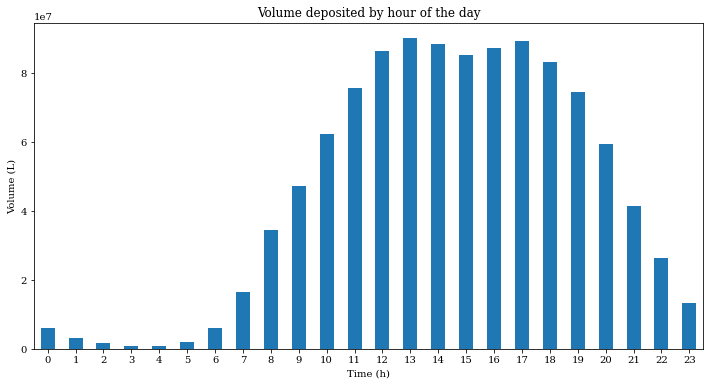

In [80]:
ax = data.groupby(data.date.dt.hour).bag_size.sum().plot.bar(figsize=(12, 6), rot=0)
ax.set_xlabel("Time (h)")
ax.set_ylabel("Volume (L)")
ax.set_title("Volume deposited by hour of the day");

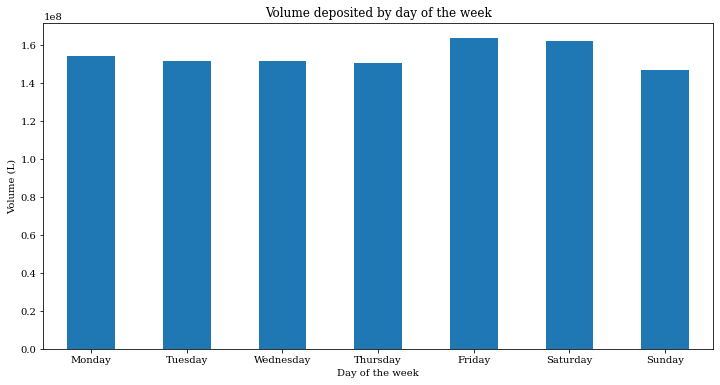

In [83]:
ax = data.groupby(data.date.dt.weekday).bag_size.sum().plot.bar(figsize=(12, 6), rot=0)
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xlabel("Day of the week")
ax.set_ylabel("Volume (L)")
ax.set_title("Volume deposited by day of the week");

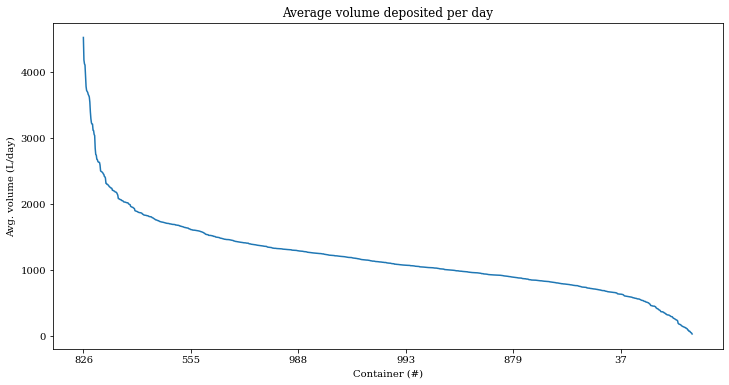

In [97]:
by_container = data.groupby(data.container)
days = (by_container.date.max() - by_container.date.min()).dt.days
by_avg_volume = by_container.bag_size.sum() / days

ax = by_avg_volume.sort_values(ascending=False).plot(figsize=(12, 6))
ax.set_ylabel("Avg. volume (L/day)")
ax.set_xlabel("Container (#)")
ax.set_title("Average volume deposited per day");

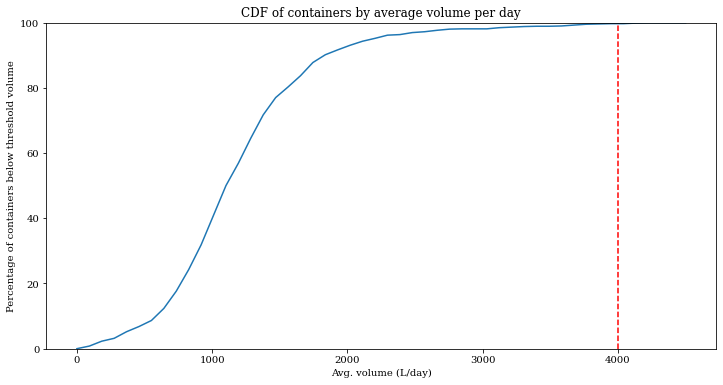

In [135]:
x = np.linspace(0, 4500)
y = [100 * by_avg_volume[by_avg_volume <= v].count() / by_avg_volume.count() for v in x]

_, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim([0, 100])
ax.plot(x, y)
ax.vlines(4000, 0, 100, color='red', linestyle='dashed')

ax.set_xlabel("Avg. volume (L/day)")
ax.set_ylabel("Percentage of containers below threshold volume")
ax.set_title("CDF of containers by average volume per day");